## Overview

In this notebook, my goal is to find duplicate transactions in a credit card transaction dataset and build a fraud prediction model using the samples in the data.

 * Import Modules
 * Download Dataset
 * Loading dataset into Dataframe
 * Structure of the Data
 * Summary Statistics
 * Histogram of the Processed Amounts of Each Transaction
 * Duplicate Transactions
   * Reversed Transaction Duplicates
   * Multiple Swipes Duplicates
   * Some interesting observation about the duplicate transactions
 * Predictive Model
   * Feature Engineering
   * Feature Selection
   * Encoding Categorical Features
   * Separate Features and Target Variable
   * Recursive Feature Selection
   * Feature Scaling
   * Check Class Imbalance
   * Re-sampling Data
   * Logistic Regression Model
   * Prediction
   * ROC Curve
   * K-fold Cross Validation
 * Future Work
 * Conclusion
   
 

## Import Modules

I am using anaconda distribution (4.9.1) of python 3.7.1

Sources of all modules are listed: <br>

[pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/install.html) <br>
[numpy](https://numpy.org/install/) <br>
[imblearn](https://imbalanced-learn.readthedocs.io/en/stable/install.html) <br>
[sklearn](https://scikit-learn.org/stable/install.html) <br>
[seaborn](https://seaborn.pydata.org/installing.html) <br>
[scikitplot](https://pypi.org/project/scikit-plot/) <br>
[matplotlib](https://pypi.org/project/matplotlib/) <br>
[datetime](https://pypi.org/project/DateTime/) <br>
[scipy](https://www.scipy.org/install.html)



In [1]:
#download and load the dataset
import urllib.request
import pandas as pd
import zipfile
import json

#calculation with matrices 
import numpy as np

#measure skewness of distribution
from scipy.stats import skew

#handle imbalanced dataset
from imblearn import under_sampling, over_sampling
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#classification
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

#visualization
import seaborn as sns
import scikitplot as skplt
from matplotlib import pyplot as plt

import datetime
import warnings 
warnings.filterwarnings('ignore')

## Download Dataset

Lets first download the dataset as zipped file and unzip it.

In [2]:
#download dataset
urllib.request.urlretrieve('https://github.com/CapitalOneRecruiting/DS/raw/master/transactions.zip', 'transactions.zip')

#unzip the data file
with zipfile.ZipFile('transactions.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

## Loading dataset into Dataframe

In [3]:
#storing each dictionary as a list element
transactions = []

with open('transactions.txt') as fp:
    for line in fp:
        transactions.append(json.loads(line))

#converting list of dictionaries into dataframe
df = pd.DataFrame(transactions)

## Structure of the Data


First see first few rows in the dataset.

In [4]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


In [5]:
#number of records and fields in the dataframe
df.shape

(786363, 29)

So there are **786,363** records and **29** fields in the dataset.

Lets take a look at the fields of the dataset.

In [6]:
list(df.columns)

['accountNumber',
 'customerId',
 'creditLimit',
 'availableMoney',
 'transactionDateTime',
 'transactionAmount',
 'merchantName',
 'acqCountry',
 'merchantCountryCode',
 'posEntryMode',
 'posConditionCode',
 'merchantCategoryCode',
 'currentExpDate',
 'accountOpenDate',
 'dateOfLastAddressChange',
 'cardCVV',
 'enteredCVV',
 'cardLast4Digits',
 'transactionType',
 'echoBuffer',
 'currentBalance',
 'merchantCity',
 'merchantState',
 'merchantZip',
 'cardPresent',
 'posOnPremises',
 'recurringAuthInd',
 'expirationDateKeyInMatch',
 'isFraud']

## Summary Statistics
Lets see a quick summary of the numerical fields in the data.

In [7]:
df.describe()

,creditLimit,availableMoney,transactionAmount,currentBalance
count,786363.000000,786363.000000,786363.000000,786363.000000
mean,10759.464459,6250.725369,136.985791,4508.739089
std,11636.174890,8880.783989,147.725569,6457.442068
min,250.000000,-1005.630000,0.000000,0.000000
25%,5000.000000,1077.420000,33.650000,689.910000
50%,7500.000000,3184.860000,87.900000,2451.760000
75%,15000.000000,7500.000000,191.480000,5291.095000
max,50000.000000,50000.000000,2011.540000,47498.810000


Now list the unique values for each field in the dataframe as **(fieldname, number of unique values, unique values)**

In [8]:
for col in df:
    print((col, df[col].nunique(), df[col].unique()))
    print()

('accountNumber', 5000, array(['737265056', '830329091', '574788567', ..., '899818521',
       '638498773', '732852505'], dtype=object))

('customerId', 5000, array(['737265056', '830329091', '574788567', ..., '899818521',
       '638498773', '732852505'], dtype=object))

('creditLimit', 10, array([ 5000.,  2500., 50000., 15000., 10000.,   250.,   500.,  1000.,
        7500., 20000.]))

('availableMoney', 521916, array([ 5000.  ,  4990.63,  4959.25, ..., 48766.15, 48716.72, 48666.83]))

('transactionDateTime', 776637, array(['2016-08-13T14:27:32', '2016-10-11T05:05:54',
       '2016-11-08T09:18:39', ..., '2016-12-27T15:46:24',
       '2016-12-29T00:30:55', '2016-12-30T20:10:29'], dtype=object))

('transactionAmount', 66038, array([ 98.55,  74.51,   7.47, ..., 482.13, 451.71, 624.07]))

('merchantName', 2490, array(['Uber', 'AMC #191138', 'Play Store', ..., 'ATT #141119',
       'EZ Wireless #200746', 'Runners #747070'], dtype=object))

('acqCountry', 5, array(['US', '', 'CAN', 'MEX', '

('enteredCVV', 976, array(['414', '486', '885', '206', '579', '539', '205', '265', '640',
       '670', '240', '630', '140', '679', '773', '173', '783', '713',
       '774', '483', '438', '433', '741', '808', '736', '779', '250',
       '440', '260', '746', '853', '726', '147', '418', '142', '172',
       '310', '436', '557', '264', '402', '202', '505', '570', '307',
       '470', '665', '781', '737', '337', '734', '692', '519', '717',
       '995', '311', '356', '350', '915', '197', '676', '647', '866',
       '461', '551', '555', '529', '329', '225', '255', '625', '671',
       '581', '963', '903', '593', '215', '956', '655', '209', '203',
       '269', '207', '128', '258', '688', '788', '981', '951', '481',
       '931', '236', '161', '151', '051', '277', '965', '449', '930',
       '317', '798', '367', '220', '120', '296', '395', '822', '596',
       '475', '584', '619', '219', '143', '613', '649', '615', '612',
       '019', '287', '639', '950', '365', '753', '067', '867', '327',


From above information, I'll now briefly describe the fields of the data to summarize domain knowledge:

### Categorical fields:

**accountNumber** : Account number of the account where transaction was made from. The dataset contains transaction from 5000 accounts.

**accountOpenDate** : Date when the account was opened.

**acqCountry** : Country where the credit card is acquired. There is 5 unique values for this field. <br>

**cardCVV** : CVV is the three digit number on credit card that adds an extra layer of security when making purchases online or over the phone. <br>

**cardLast4Digits** : Last 4 digits of the credit card.

**currentExpDate** : Expiry date of the card.

**customerID** : ID of the customer making the transaction. The dataset contains transaction of 5000 customers.

**dateOfLastAddressChange** : The date the account holder last changed his/her address.

**enteredCVV** : CVV entered by the customer during the transaction.

**expirationDateKeyInMatch** : If the expired date entered by the customer matched with original. This is a boolean field.

**isFraud** : If the transaction was found to be fraud or not. This is a boolean field.

**merchantCategoryCode** : Category of the merchant that was selling the product/service. There are 19 unique categories.<br>

**merchantCity** : City the merchant located in.

**merchantCountryCode** : Code of the county the merchant located in. It can take 5 different values.

**merchantName** : Name of the merchant/seller. The data shows transactions with 2490 merchants.

**posConditionCode** : This field contains a code identifying transaction conditions at the point-of-sale or point-of-service. 4 unique values available.

**posEntryMode** : This two-digit code identifies the actual method used to enter the cardholder account number and card expiration date. 6 unique values available.

**transactionDateTime** : Time when the transaction took place.

**transactionType** : Category the transaction falls into. 4 different types available.


### Numerical fields:

**creditLimit** : Credit limit in the account. It can take 10 different values.

**availableMoney** : Amount of money available in the account.

**currentBalance** : Total amount of due/balance in the credit card.

**transactionAmount** : Amount of the transaction in dollars.

Lets now count **null/empty values** for each field.

In [9]:
for col in df:
    
    if df[col].dtype == 'object' and df[df[col] == ''].shape[0] > 0: 
        
        #for categorical data type
        print(col, df[df[col] == ''].shape[0])
    
    elif df[col].isna().sum() > 0:
        #for numerical data type
        print(col, df[col].isna().sum())

acqCountry 4562
merchantCountryCode 724
posEntryMode 4054
posConditionCode 409
transactionType 698
echoBuffer 786363
merchantCity 786363
merchantState 786363
merchantZip 786363
posOnPremises 786363
recurringAuthInd 786363


## Histogram of the Processed Amounts of Each Transaction

Let's plot a histogram of the transaction amounts and see what the distribution looks like.

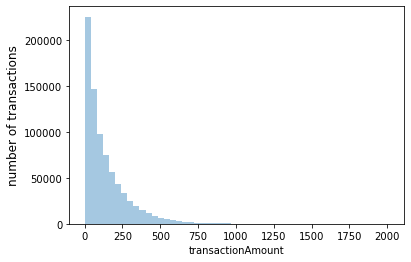

In [10]:
sns.distplot(df['transactionAmount'] , hist = True, kde = False)
plt.ylabel('number of transactions', fontsize=12)
plt.show()

In [11]:
print( 'skewness of normal distribution (should be 0): {}'.format( skew(df['transactionAmount']) ))

skewness of normal distribution (should be 0): 2.0922422738206343


From both the plot and skewness ( > 0) it's clear that the distribution of transactions is **right skewed**, that means
   * It is not symmetric around the mean.
   * The mean is greater than the median. 
   * The tail of the distribution on the right hand (positive) side is longer than on the left hand side.

My hypothesis is - **credit card usage is mostly popular for small transactions**.

## Duplicate Transactions

In my opinion **accountNumber**, **merchantName**, **transactionType**, **transactionAmount** and **transactionDateTime** are the necessary fields to identify duplicate transacations. I'll first create a dataframe selecting these fields only.

In [12]:
dfUniqueTransaction = df[['accountNumber', 'merchantName', 'transactionType', 'transactionAmount', 'transactionDateTime']]

### Reversed Transaction Duplicates

First find the total count of duplicates that resulted from **reversed transactions**. These duplicate happens when a purchase is followed by a reversal.

The idea is as follows:
 * Split the dataframe in two parts based on the transaction type, one for **PURCHASE** and another for **REVERSAL**.
 * I assumed for every reversal transaction, there exists **at most one** corresponding purchase transaction. There can be reversal purchase record in the dataset that does not have any any matching purchase transaction.
 * I assumed a purchase transaction that occured earlier than a reversal purchase having same *account name*, *merchant name* and *transaction amount* is basically a duplicate of the reversal purchase.
 * For each reversal transaction, I checked what purchase transaction exists that has the same *account name*, *transaction amount* and *merchant name* as the reversal transaction, but happened in an earlier time. I did not set a threshold for time gap here, because sometimes merchants refund a customer even several months after the purchase depending on their policy.
 

In [13]:
# #create two dataframes for two types of transaction
# dfPurchase = dfUniqueTransaction[dfUniqueTransaction['transactionType'] == 'PURCHASE']
# dfReversal = dfUniqueTransaction[dfUniqueTransaction['transactionType'] == 'REVERSAL']

# #count of number of duplicates and total amount 
# totalReversedDuplicates = 0
# totalReversedDuplicatesAmount = 0

# dfPurchaseSameAccount = None
# prevAccountNumber = None

# for _, row in dfReversal.iterrows():
    
#     #extracting transactions from the purchase dataframe with the account same account number as the reversal transaction
#     #to save computation time. As account numbers grouped together in the dataframes, if I encounter a transaction from the
#     #same account during the iteration, I don't have to repeat the extraction step.
#     if row['accountNumber'] != prevAccountNumber:
#         dfPurchaseSameAccount = dfPurchase[dfPurchase['accountNumber'] == row['accountNumber']]
#         prevAccountNumber = row['accountNumber']
        
#     #checking if there exists any purchase transaction with the same account name, merchant name and transaction amount
#     #as the reversal transaction, where the purchase took place earlier 
#     if ((dfPurchaseSameAccount['transactionAmount'] == row['transactionAmount']) & 
#         (dfPurchaseSameAccount['merchantName'] == row['merchantName']) & 
#         (row['transactionDateTime'] > dfPurchaseSameAccount['transactionDateTime'])).any():
        
#         totalReversedDuplicates += 1
#         totalReversedDuplicatesAmount += row['transactionAmount']

# print('Total number of reversal duplicates: ', totalReversedDuplicates)
# print('Total dollar amount of reversal duplicates: $', totalReversedDuplicatesAmount)
# print('Mean amount of reversal duplicates: $', totalReversedDuplicatesAmount/totalReversedDuplicates)

### Multiple Swipes Duplicates

Now let's find the duplicates resulted from multiple swipes of the credit card. These duplicates happen when a vendor accidentally charges a customer's card multiple times within a short time span.

The idea is as follows:
 * I analyzed the dataset and found that transactions are grouped by account number in the dataset. Also a group of transactions having same account number are ordered by increasing time stamp.
 * If a purchase transaction occurs within a specific time of another purchase transaction with same account number, merchant name and transaction amount, I will consider them as duplicates.
 * I am assuming all multiple swipes occurs within a duration of **2 minutes (= 120 seconds)**. Thus if a purchase meets all specification of multiple swipes but occurs within a time difference more than 2 minutes I will consider it a valid transaction. The rationale behind this 2 minute assumption is multiple swipes practically occur within a short period of time.
 * For a purchase transaction, there can exist any number (including zero) of multiple swipes in the dataset.
 * For each purchase transaction, I iterated over the next purchase transactions for the same account number that occured within 2 minutes. If any of those purchase has same account number, merchant number and transaction amount I will count it as a duplicate.
 * I excluded the first transaction from the set of duplicate transaction. The first one is considered valid transaction, while rest will be treated as duplicates.
 


In [14]:
# #assigning new index to the purchase transaction dataframe because we will iterate over index here
# dfPurchase = dfPurchase.reset_index(drop=True)

# #count of number of duplicates and total amount
# totalMultiSwipeDuplicates = 0
# totalMultiSwipeDuplicatesAmount = 0

# lastSeenDuplicateTransaction = -1

# #this outer loop selects a valid transaction
# for index1, row in dfPurchase.iterrows():
        
#     if index1 < lastSeenDuplicateTransaction:
#         continue
        
#     #this inner loops selects a duplicate transaction     
#     for index2 in range(index1+1, dfPurchase.shape[0]):
        
#         #if encounter a transaction with different account number, we don't need to search any further
#         if row['accountNumber'] != dfPurchase.iloc[index2]['accountNumber']:
#             break
            
#         t1 = pd.to_datetime(row['transactionDateTime'])
#         t2 = pd.to_datetime(dfPurchase.iloc[index2]['transactionDateTime'])
        
#         #checking if the valid transaction and its candidate duplicate occured within a specific timeframe
#         if pd.Timedelta(t2 - t1).seconds > 120:
#             break
        
#         #if merchant name and transaction name matches with valid transaction, then a duplicate is found
#         if (row['merchantName'] == dfPurchase.iloc[index2]['merchantName']) and (row['transactionAmount'] == dfPurchase.iloc[index2]['transactionAmount']):
#             totalMultiSwipeDuplicates += 1
#             totalMultiSwipeDuplicatesAmount += row['transactionAmount']
#             lastSeenDuplicateTransaction = index2    

# print('Total number of multiple swipes duplicates: ', totalMultiSwipeDuplicates)
# print('Total dollar amount of multiple swipes duplicates: $', totalMultiSwipeDuplicatesAmount)
# print('Mean amount of multiple swipes duplicates: $', totalMultiSwipeDuplicatesAmount/totalMultiSwipeDuplicates)

### Some interesting observation about the duplicate transactions:

* Five fields in the dataset were particularly important to identify both types of duplicate transactions
    * accountNumber
    * merchantName
    * transactionType
    * transactionAmount
    * transactionDateTime
    
    
* Number of duplicates by multiple swipes increases if time gap is made more flexible. Fixing a time gap threshold needs proper  domain knowledge about credit card transaction and real life observation of such occurrences.


* While the mean transaction amount for both type of duplicates (reversed and multiple swipe) is equal (\\$150), it is much higher than mean of all transaction amount (\\$136). It is possible that the duplicate transactions comes from a different distribution than the regular transaction.

## Predictive Model

I will now show how to build a predictive model to detect fraudulent transactions. This is a classification problem where dependent/target variable is **isFraud**. Being a boolean type categorical variable, it can take two values ['True', 'False'].

Let's quickly check the mean value for the numeric and boolean features in the dataset for both target class labels.

In [15]:
df.groupby('isFraud').mean()

,creditLimit,availableMoney,transactionAmount,currentBalance,cardPresent,expirationDateKeyInMatch
isFraud,,,,,,
False,10754.884062,6252.455386,135.570249,4502.428675,0.451469,0.001331
True,11044.958525,6142.894186,225.215905,4902.064338,0.278248,0.001047


From our observation we can see these features has important role to play in classifying a transaction as fraud or not, as their mean differs for both classes to some extent. For example, **transactionAmount** appears to be a valuable feature due to its mean pretty much different for fraudulent (225.2) and non-fraudulent class (135.6).

Now let's check the class balance for a random feature in the dataset, e.g. **merchantCountryCode**.

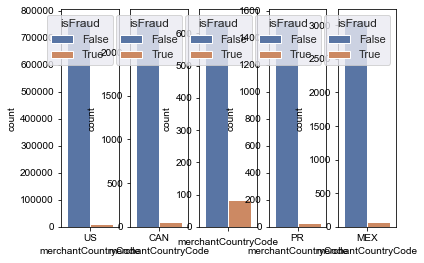

In [16]:
col = 'merchantCountryCode'

fig, ax = plt.subplots(1, df[col].nunique())
sns.set(rc={'figure.figsize':(15, 4)})

for index, value in enumerate(df[col].unique()):
    sns.countplot(x=col, hue='isFraud', data=df[df[col]== value], ax=ax[index])
fig.show()

It is clear from the figure that transactions with missing value for **merchantCountryCode** have suprisingly higher ratio than others. This anomaly can be useful for the classification.

### Feature Engineering

Feature engineering is about creating new input features from the existing ones.

First I'm creating a new field **CVVmatched** that shows if entered CVV matched with original CVV. This boolean feature is created using existing features **enteredCVV** and **cardCVV**.

In [17]:
df['CVVmatched'] = df['enteredCVV'] == df['cardCVV']

Creating another feature **accountAge** that shows the age of the account (from it creation to current transaction). This feature has numerical data type, created using **transactionDateTime** and **accountOpenDate**.

In [18]:
df['accountAge'] = pd.to_datetime(df['transactionDateTime']) - pd.to_datetime(df['accountOpenDate'])
df['accountAge'] = df['accountAge'].dt.total_seconds()

Adding a new feature **addressAge** that shows what how long (in seconds) the cardholder has been living in his present address when the transaction was being made. Created it from existing features  **transactionDateTime** and **dateOfLastAddressChange**.

In [19]:
df['addressAge'] = pd.to_datetime(df['transactionDateTime']) - pd.to_datetime(df['dateOfLastAddressChange'])
df['addressAge'] = df['addressAge'].dt.total_seconds()

The last feature we will add is **validityLeft** which tells us how long the card is valid starting from the moment of the transaction. Created it from existing features **currentExpDate** and **transactionDateTime**.

In [20]:
df['validityLeft'] = pd.to_datetime(df['currentExpDate']) - pd.to_datetime(df['transactionDateTime'])
df['validityLeft'] = df['validityLeft'].dt.total_seconds()

### Feature Selection

In this part, we will remove some features which are not necessary for our classification purpose. We will keep the rest of the features as independent variables. 

First extract the **constant features**, that has the same value for all rows. Constant features provide no information that can help in classification of the record at hand. Therefore, it is advisable to remove all the constant features from the dataset.

In [21]:
nunique = df.apply(pd.Series.nunique)
constantColumnNames = nunique[nunique == 1].index
list(constantColumnNames)

['echoBuffer',
 'merchantCity',
 'merchantState',
 'merchantZip',
 'posOnPremises',
 'recurringAuthInd']

Now removing these features from the dataframe.

In [22]:
df.drop(columns=constantColumnNames, axis=1, inplace=True)

If there are fields that are duplicates (another column exists with same value in each row), we should remove one of the duplicate columns. Below we found that **customerId** is a duplicate field.

In [23]:
#source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/

duplicateColumnNames = set()
# Iterate over all the columns in dataframe
for x in range(df.shape[1]):
    # Select column at xth index.
    col = df.iloc[:, x]
    # Iterate over all the columns in DataFrame from (x+1)th index till end
    for y in range(x + 1, df.shape[1]):
        # Select column at yth index.
        otherCol = df.iloc[:, y]
        # Check if two columns at x 7 y index are equal
        if col.equals(otherCol):
            duplicateColumnNames.add(df.columns.values[y])
duplicateColumnNames = list(duplicateColumnNames)
duplicateColumnNames

['customerId']

Lets drop **customerId** field

In [24]:
df.drop(columns=duplicateColumnNames, axis=1, inplace=True)

Now calculate the **correlation matrix** with the remaining features and see if there are features that have strong positive/negative correlation.

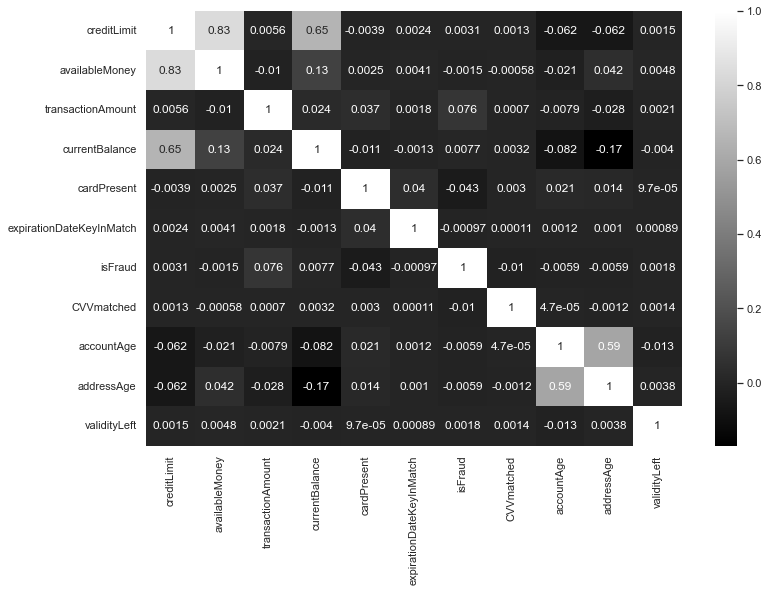

In [25]:
plt.subplots(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="gist_gray")
plt.show()

Dropping **creditLimit** because features **creditLimit** and **availableMoney** are highly correlated (ρ = 0.83).

In [26]:
df.drop(columns=['creditLimit'], axis=1, inplace=True)

Now lets remove fields that contains a large number of unique values. A feature with large number of labels creates **overfitted model**.

In [27]:
df.drop(columns=['currentExpDate', 'merchantName', 'accountOpenDate',  'cardLast4Digits',  'dateOfLastAddressChange', 'transactionDateTime', 'accountNumber', 'cardCVV', 'enteredCVV'], axis=1, inplace=True)

In [28]:
print(df.columns)

Index(['availableMoney', 'transactionAmount', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'transactionType', 'currentBalance',
       'cardPresent', 'expirationDateKeyInMatch', 'isFraud', 'CVVmatched',
       'accountAge', 'addressAge', 'validityLeft'],
      dtype='object')


### Encoding Categorical Features

In this step, I will create **one-hot encodings** for categorical variables. This will create boolean feature for each of the label of the original feature.

In [29]:
df = pd.get_dummies(df, columns=['acqCountry', 'transactionType', 'posConditionCode' , 'merchantCategoryCode', 'merchantCountryCode', 'posEntryMode' ])

### Separate Features and Target Variable

Now we will split the columns of the data in two groups, feature and target variable.

Let's create a dataframe with **isFraud** feature, which is the target variable (y). Create a separate dataframe with rest of the features, that will represent the feature variables (X).

In [30]:
y = df[['isFraud']]
X = df.drop(columns=['isFraud' ], axis=1)

### Recursive Feature Selection

In [31]:
list(X.columns)

['availableMoney',
 'transactionAmount',
 'currentBalance',
 'cardPresent',
 'expirationDateKeyInMatch',
 'CVVmatched',
 'accountAge',
 'addressAge',
 'validityLeft',
 'acqCountry_',
 'acqCountry_CAN',
 'acqCountry_MEX',
 'acqCountry_PR',
 'acqCountry_US',
 'transactionType_',
 'transactionType_ADDRESS_VERIFICATION',
 'transactionType_PURCHASE',
 'transactionType_REVERSAL',
 'posConditionCode_',
 'posConditionCode_01',
 'posConditionCode_08',
 'posConditionCode_99',
 'merchantCategoryCode_airline',
 'merchantCategoryCode_auto',
 'merchantCategoryCode_cable/phone',
 'merchantCategoryCode_entertainment',
 'merchantCategoryCode_fastfood',
 'merchantCategoryCode_food',
 'merchantCategoryCode_food_delivery',
 'merchantCategoryCode_fuel',
 'merchantCategoryCode_furniture',
 'merchantCategoryCode_gym',
 'merchantCategoryCode_health',
 'merchantCategoryCode_hotels',
 'merchantCategoryCode_mobileapps',
 'merchantCategoryCode_online_gifts',
 'merchantCategoryCode_online_retail',
 'merchantCatego

As we see above, the number of features is too high even after performing a feature selection step. This happened due to adding new features that I did through feature engineering and one-hot encoding.

With all the remaining feature variables, I will perform one final step of feature selection. Here, given an external estimator that assigns weights to features, the goal of **recursive feature elimination (RFE)** is to select features by recursively considering smaller and smaller sets of features.

In [32]:
logreg = LogisticRegression()
rfe = RFE(logreg, n_features_to_select=20)
rfe = rfe.fit(X, y.values.ravel())

selectedColumns = pd.Series(rfe.support_)
X = X[X.columns[selectedColumns]]

Let's check the final list of features below.

In [33]:
list(X.columns)

['availableMoney',
 'transactionAmount',
 'currentBalance',
 'cardPresent',
 'CVVmatched',
 'accountAge',
 'addressAge',
 'validityLeft',
 'acqCountry_US',
 'transactionType_PURCHASE',
 'posConditionCode_01',
 'posConditionCode_08',
 'merchantCategoryCode_entertainment',
 'merchantCategoryCode_fastfood',
 'merchantCategoryCode_food',
 'merchantCategoryCode_fuel',
 'merchantCategoryCode_hotels',
 'merchantCountryCode_US',
 'posEntryMode_02',
 'posEntryMode_05']

### Feature Scaling

Feature scaling (also known as data normalization) is the method used to standardize the range of features of data. Since, the range of values of data may vary widely, it becomes a necessary step in data preprocessing before fitting the data in the model.

In [34]:
scaled_features = StandardScaler().fit_transform(X.values)
X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

### Check Class Imbalance

Data suffers class imbalance problem when the class distributions are highly imbalanced, i.e. almost all sample belong to one majority class. Many classification algorithms have low predictive accuracy for the infrequent class. 

Let's check if our dataset suffers from class imbalance.

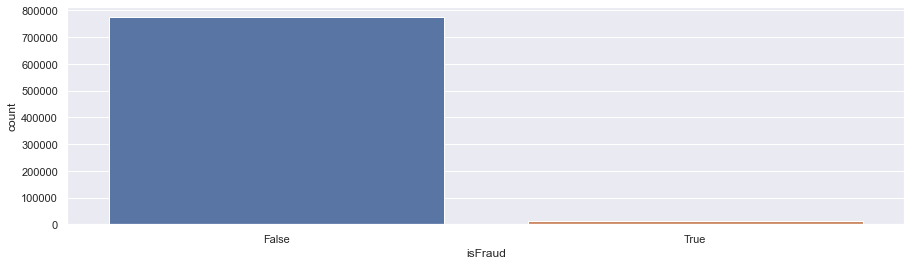

In [35]:
sns.countplot(x='isFraud', data = df)
plt.show()

From the figure above it's clear that the dataset is **highly imbalanced**.

### Re-sampling Data

I will now re-sample the dataset to get a balanced training data.

Here I followed of a hybrid sampling method, that performs both oversampling and undersampling of the data.

 * During oversampling, it creates duplicates of the minority class ('True') so that the ratio between minority and majority class increases. However, I chose a low ratio during oversampling, because creating too much duplication will cause overfitting.
 
 * While undersampling, it reduces the ratio by removing many samples in the majority class. This causes loss of information. Still it helps to make a balanced data.

In [36]:
def resampling(X, y):
    # define pipeline for hybrid
    over = SMOTE(sampling_strategy=0.1)
    under = RandomUnderSampler(sampling_strategy=1)
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)
    return pipeline.fit_resample(X, y)

### Logistic Regression Model

Logistic regression is undoubtedly the first thing to try and one of the most appropriate classifiers to use for binary classification.

The reason for using Logistic Regression is:
 * Its outputs have a nice probabilistic interpretation, that very much suitable for a binary classification problem like this.
 * The algorithm can be regularized to avoid overfitting. My model uses L2 regularization.
 * Logistic models can be updated easily with new data using stochastic gradient descent.

In [37]:
def model(X_train, X_test, y_train, y_test):
    
    clf = LogisticRegression(penalty='l2', solver='saga', class_weight='balanced',
                                          tol=1e-3, max_iter=1000000,
                                          warm_start=True, random_state=42,
                                          intercept_scaling=1000)

    clf.fit(X_train , np.ravel(y_train))
    
    predict = clf.predict(X_test) 
    predict_proba = clf.predict_proba(X_test) 

    return predict, predict_proba

### Prediction

As practiced by many, I also follow the rule of thumb to use 80% data for training.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now I will resample the **training data** to get a balanced dataset. 

**Caution**: I'm doing it **only for the training data** because the test data should stay untouched. Changing the test data from the observation of the training data is data manipulation that creates synthetic test dataset leading to manipulated  prediction accuracy.

In [39]:
X_train, y_train = resampling(X_train, y_train)

Now after resampling, the training data looks balanced!

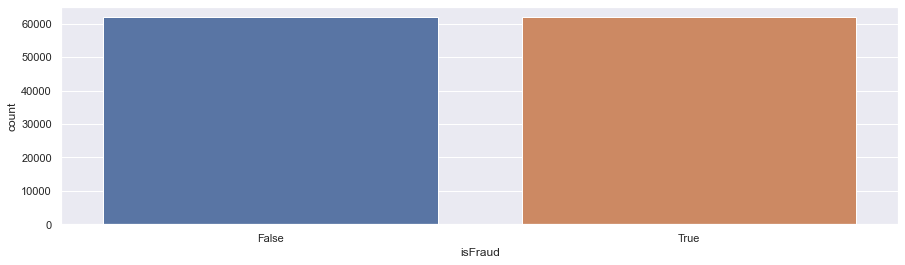

In [40]:
sns.countplot(x='isFraud', data = X_train.join(y_train))
plt.show()

Now I will train the logistic regression model with training data and then get the prediction result using the test data.

In [44]:
predict, predict_proba  =  model(X_train, X_test, y_train, y_test)

Let's now generate the confusion matrix to get an overview of different classifcation test measurements.

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

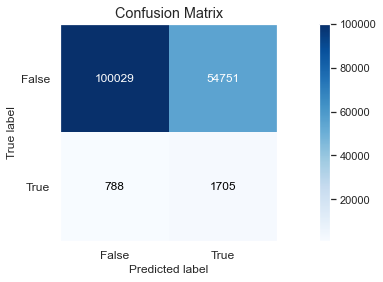

In [45]:
skplt.metrics.plot_confusion_matrix(y_test, predict)

It shows that the model is **correctly** classifying many cases as fraudulent, but at the same time it is **incorrectly** classifying many non-fraudulent cases as fraudulent.

Now let's take a look at the accuracy score.

In [46]:
print(accuracy_score(y_test, predict))

0.6468624620882161


However, **accuracy is a poor metric** for measuring performance of classifiers, as test data can be imbalanced. Thus we will now check *ROC curve and AUC score*.

### ROC Curve

ROC curve is the most reliable performance measurement for classification problem. ROC is a probability curve and AUC represents degree or measure of separability (area under the ROC curve). It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting if a transaction is fraudulent or not.

Text(0.5, 0, 'False positive rate')

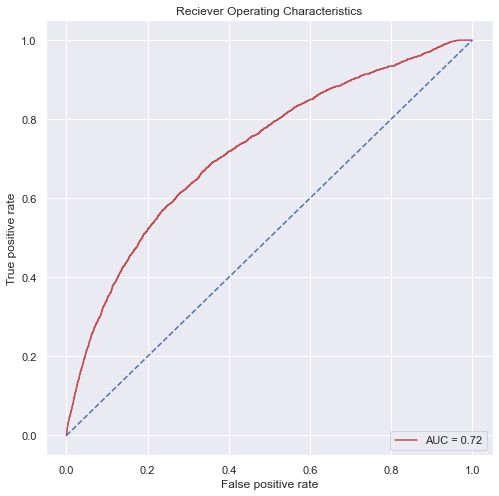

In [47]:
#calculating ROC from False Positive Rate and True Positive Rate
fpr,tpr, threshold = roc_curve(y_test, predict_proba[:,1], pos_label=True)
roc_auc_ = auc(fpr,tpr)

#plotting the ROC curve
plt.figure(figsize=(8,8))
plt.title('Reciever Operating Characteristics')
plt.plot(fpr,tpr,'r',label = 'AUC = %0.2f' % roc_auc_)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'b--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

From the graph, AUC score is **0.70**

In machine learning, AUC score **0.7~0.8** is considered as acceptable. Thus I can say that my model touches the margin of acceptability, yet there is plenty room for improvement to get the model to a very good AUC score.  

### K-fold Cross Validation

Cross-validation is used in applied statistics to estimate the skill of a predictive on unseen data.  It uses a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data unseen during the training of the model.

The **'K'** in K-fold Cross Validation refers to the number of groups that a given data sample is to be split into. I am using k=10 here, thus it becomes ten-fold cross-validation.

In [49]:
kf = KFold(n_splits=10)
auc_scores = []

k = 1

for train_index, test_index in kf.split(X):
    X_train, X_test = np.array(X)[train_index], np.array(X)[test_index]
    y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]
    
    X_train, y_train = resampling(X_train, y_train)
    predict, predict_proba = model(X_train, X_test, y_train, y_test)
    
    auc_score = roc_auc_score(y_test, predict)
    print('AUC score for fold #'+str(k)+' : ', auc_score)
    auc_scores.append(auc_score)
    k+= 1

print("Mean AUC score: ", sum(auc_scores)/len(auc_scores))

AUC score for fold #1 :  0.6210423816721181
AUC score for fold #2 :  0.664128819657355
AUC score for fold #3 :  0.6985956797373234
AUC score for fold #4 :  0.6934735718966554
AUC score for fold #5 :  0.670571720454103
AUC score for fold #6 :  0.6889711906420791
AUC score for fold #7 :  0.6381772173536137
AUC score for fold #8 :  0.6783079117949494
AUC score for fold #9 :  0.6123829199883123
AUC score for fold #10 :  0.6921341912264646
Mean AUC score:  0.6657785604422973


## Future Work

* Currently, my algorithm for finding transaction duplicates runs very slow (takes several minutes in my machine). With efficient implementation of data structures and searching techniques, I belive the execution time can be improved a lot.
 
* Grid Search should help to efficiently find the best model  applying different combinations of hyperparameters. To improve the AUC score, I believe grid search would help. 

* I would like to apply ensemble methods as learning algorithm. Bagging models like Random Forest would help to handle missing values in the data and avoid overfitting. Boosting models like Gradient Boosting and Adaboost would help effectively handing the highly imbalanced dataset.

* I considered '' or empty string values as a distinct class label in my dataset. Even though it is one of three common techniques of handling missing data (the other two being (i) replacing with most frequent value and (ii) converting the feature to a boolean feature where missing values will be assigned to one class and rest of the values fall into the other class), I should explore the other two techniques.

* During data preprocessing I did not perform outlier detection. I want to improve the data quality removing noise and outliers from the dataset so that I can mitigate the overfitting problem.

* For testing, I am currently partitioning the given samples in train and test set. Technically this should be called validation set, instead of test set. And the real test phase should be conducted with unseen unlabeled dataset (preferably real world data, instead of synthetically created) and see how my model practically performs.

## Conclusion

Even though the AUC score touches the bare minimum range of acceptability (0.7 ~ 0.8), my model is far away from being satisfactory. Thus I would like to focus into the tasks listed in the future work to improve the classifier. There is also room for improvement in my proposed duplicate detection algorithm.